In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import scipy as sp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from  sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR

### Data Loading

In [2]:
npz = np.load('ECoG.npz')
npz.files

['Yall', 'Fe', 'Xall']

In [3]:
data = np.concatenate((npz['Xall'], npz['Yall']), axis=1)
data.shape

(3327, 65)

In [4]:
df= pd.DataFrame(data)
df = df.add_prefix("Captor_")
df = df.rename(columns = {'Captor_64':'Y'})

In [5]:
display(df)

,Captor_0,Captor_1,Captor_2,Captor_3,Captor_4,Captor_5,Captor_6,Captor_7,Captor_8,Captor_9,Captor_10,Captor_11,Captor_12,Captor_13,Captor_14,Captor_15,Captor_16,Captor_17,Captor_18,Captor_19,Captor_20,Captor_21,Captor_22,Captor_23,Captor_24,Captor_25,Captor_26,Captor_27,Captor_28,Captor_29,Captor_30,Captor_31,Captor_32,Captor_33,Captor_34,Captor_35,Captor_36,Captor_37,Captor_38,Captor_39,Captor_40,Captor_41,Captor_42,Captor_43,Captor_44,Captor_45,Captor_46,Captor_47,Captor_48,Captor_49,Captor_50,Captor_51,Captor_52,Captor_53,Captor_54,Captor_55,Captor_56,Captor_57,Captor_58,Captor_59,Captor_60,Captor_61,Captor_62,Captor_63,Y
0,-1.373784,-1.303035,0.437292,0.059073,-1.233543,-1.851800,0.192090,-1.280472,0.477064,-1.127756,-0.698953,-0.369170,-0.366585,0.049470,0.936442,-0.273094,-0.219966,1.427053,0.229859,0.090326,-2.703053,-1.141280,1.145552,0.735214,-1.101865,0.439257,-0.319844,-3.110375,1.268329,2.351084,0.918831,0.861341,-1.015954,-2.078343,0.956684,-0.056063,-0.191476,-0.193933,-0.988445,-2.207386,-0.071948,-2.649964,0.022239,-0.473065,-0.471109,-0.213705,0.598678,-0.024120,-0.041721,-0.696580,-1.577198,0.886209,-0.036294,0.088028,-2.499506,0.087896,0.133129,-2.474150,-0.454107,-0.653739,0.310888,-0.933925,1.114216,-3.129836,-0.725658
1,-1.407545,-1.312102,0.681263,0.146939,-1.088221,-1.876235,0.303741,-0.965437,0.742705,-1.023152,-0.461798,-0.446029,-0.416661,-0.183948,0.842191,-0.327374,-0.285364,1.684736,0.237254,0.141029,-2.653568,-1.044011,1.159336,0.914832,-1.367357,0.334113,-0.168066,-3.069986,1.266273,2.306082,1.038455,1.019609,-0.833090,-1.883637,1.336594,-0.215107,0.140140,0.252903,-0.826509,-2.216017,0.125422,-2.454622,-0.122423,-0.660367,-0.207282,-0.109610,0.515368,0.061337,0.026490,-0.627262,-1.588243,0.985231,-0.199408,0.332187,-2.592197,0.259490,0.427158,-1.759404,-0.701379,-0.565234,0.313579,-1.320308,1.151828,-3.113451,-0.722193
2,-1.226281,-1.500977,0.857063,0.220805,-0.867141,-2.016507,0.615744,-0.770742,0.689548,-1.199206,-0.437006,-0.595407,-0.447184,-0.587790,0.674456,-0.452302,-0.579894,1.710122,0.224171,0.053490,-2.621829,-0.999433,1.129407,0.869142,-1.463398,0.172356,0.019866,-2.872113,1.220244,2.064778,1.049600,1.027413,-0.754079,-1.745427,1.432050,-0.293682,0.590331,0.590780,-0.621552,-2.019670,0.292504,-2.209368,-0.362670,-0.960632,-0.020707,0.071950,0.296889,0.161425,0.003426,-0.546336,-1.551537,0.840723,-0.324747,0.441780,-2.483678,0.423762,0.340894,-1.053777,-1.076529,-0.614602,0.195384,-1.727330,1.122682,-3.120096,-0.718729
3,-0.982472,-1.936599,0.915320,0.210657,-0.673579,-2.308089,0.470972,-0.723680,0.410033,-1.257475,-0.721862,-0.844114,-0.431515,-0.991174,0.421797,-0.568188,-0.789506,1.638904,0.101935,-0.181269,-2.579483,-0.980985,1.102521,0.703509,-1.417276,-0.049437,0.145044,-2.605998,1.326374,1.781141,0.908748,1.012274,-0.841576,-1.750504,1.409860,-0.372165,0.673782,0.822977,-0.458052,-1.779953,0.335791,-2.014000,-0.654938,-1.333846,0.087938,-0.052183,0.117902,0.118204,-0.057294,-0.464572,-1.497802,0.614156,-0.454792,0.510966,-2.411771,0.560276,0.245660,-0.405802,-1.146079,-0.627564,0.040090,-2.003656,1.027782,-3.102423,-0.701405
4,-0.764777,-2.331644,0.947733,0.097224,-0.508329,-2.409294,0.311116,-0.753455,0.232445,-1.115413,-1.004971,-1.174291,-0.526672,-1.503609,0.159811,-0.721681,-0.814583,1.449630,-0.010089,-0.227838,-2.370593,-0.878245,1.048658,0.459677,-1.299127,-0.111580,0.372603,-2.291530,1.472709,1.430336,0.663558,0.884767,-0.843536,-1.653343,1.474057,-0.644269,0.407902,0.975511,-0.410474,-1.623219,0.426632,-1.897128,-0.743491,-1.619988,0.160526,-0.106526,0.051583,0.139317,-0.056789,-0.359335,-1.453369,0.416816,-0.462709,0.603839,-2.359648,0.656457,0.316400,0.091822,-1.366580,-0.635266,-0.147546,-2.150339,0.783819,-3.025339,-0.684082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Each sample of the dataset is composed of 64 features and one single output:

* The 64 features are the signals measured with 64 independant captors placed directly on the exposed surface of the brain.
* The output is a measure of the finger flexion.

The index of the DataFrame is the time  

### Visualization

Text(0.5, 0, 'Time')

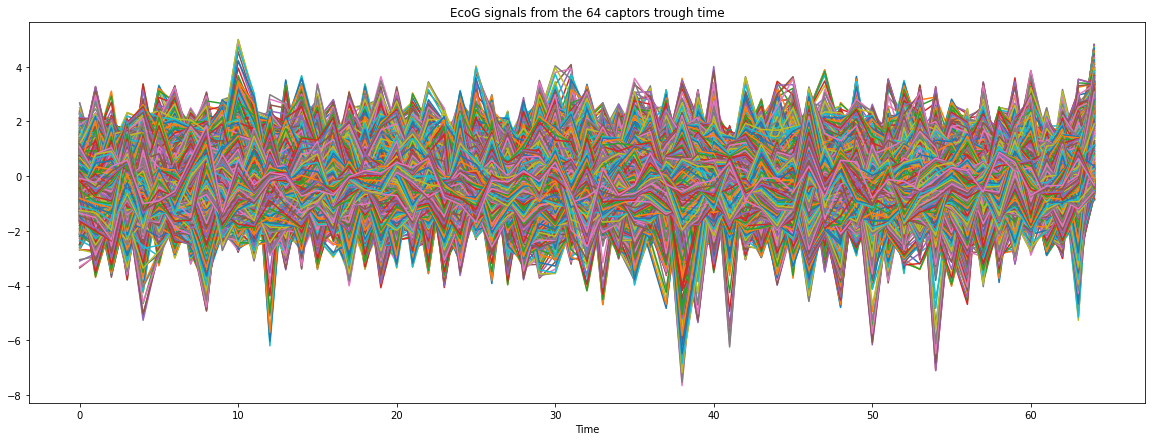

In [6]:
fig = plt.figure(figsize=(20, 7))

for i in range(0, df.shape[0]):
    plt.plot(df.iloc[i].values)

plt.title("EcoG signals from the 64 captors trough time")
plt.xlabel("Time")

The plot on the 64 EcoG signals is difficult to interpret. We can only highlight the fact that the majority of values is between -2 and 2. Therefore, we will not standardize our data

Text(0.5, 0, 'Time')

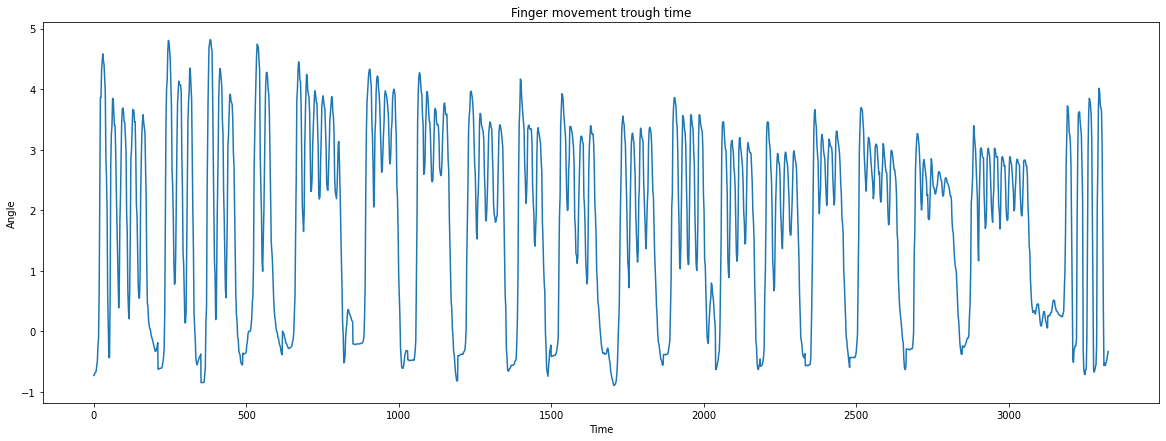

In [7]:
fig = plt.figure(figsize=(20, 7))
df['Y'].plot()
plt.title("Finger movement trough time")
plt.ylabel("Angle")
plt.xlabel("Time")

The plot on finger movement trough time is interesting. We can notice multiple movement "phases". At the beginning of a phase the angle is very low then it suddenly goes very high and finally oscillates between both previous extremums. We can imagine that during a "phase" the finger makes multiple flexions. This "phases" separation makes sense because the documentation on this study explains that during the 10 minutes of the experiment, the subjects were cued multiple times to move one of their fingers. Each cue lasted 2 seconds, and during this cue the subject moved the requested finger 3-5 times.
This explains why we can see multiple phases on the plot: each phase corresponds to a cue. At the beginning of the cue the finger is at his initial position (angle very low). Then when the cue starts it makes the first flexion (which is the highest. Finally, during the cue the subject moves his finger 3-5 times, this explains the oscillation during the “phase”.

Text(0.5, 0, 'Position 45')

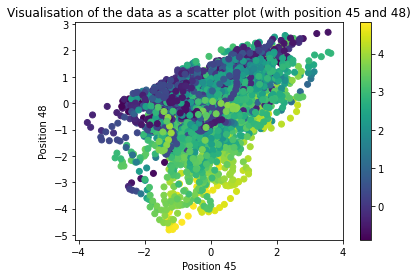

In [8]:
fig, ax = plt.subplots()
shw = ax.scatter(df["Captor_45"], df["Captor_48"],c=df["Y"])
bar = plt.colorbar(shw)
plt.title("Visualisation of the data as a scatter plot (with position 45 and 48)")
plt.ylabel("Position 48")
plt.xlabel("Position 45")

In this scatter plot the angles (Yall) are controlling the color. We can notice the separation between rougly 4 colors (Blue, dark green, light green, yellow). The blue points correpond to low angles, the yellow points correspond to high angles, and dark/light green points both correpond to "intermediate" angles. This separation recalls the configuration of a "phase" (described in the previous discussion). The blue points correspond to the beginning of a phase (initial finger position), and the minimums during the oscillation. The yellow points correspond to the first flexion (very high). Finally both dark and light green correspond to the movement during the oscillation (without extremums).

To sum up :

Blue => finger is low

Dark/Light green => finger is in the middle

Yellow => finger is high

### Preprocessing

In [9]:
n_training_data = 1000

train_df = df.iloc[:n_training_data,:]

test_df = df.iloc[n_training_data:,:]

In [10]:
captors = ["Captor_" + str(i) for i in range(0,64)]

In [11]:
Xtrain = train_df[captors]
Ytrain = train_df['Y']
Xtest = test_df[captors]
Ytest = test_df['Y']

### Linear Regression

In [12]:
LR = LinearRegression()
LR.fit(Xtrain,Ytrain)
w = LR.coef_.reshape(64,1)

predictions_train = LR.predict(Xtrain)
predictions_test = LR.predict(Xtest)

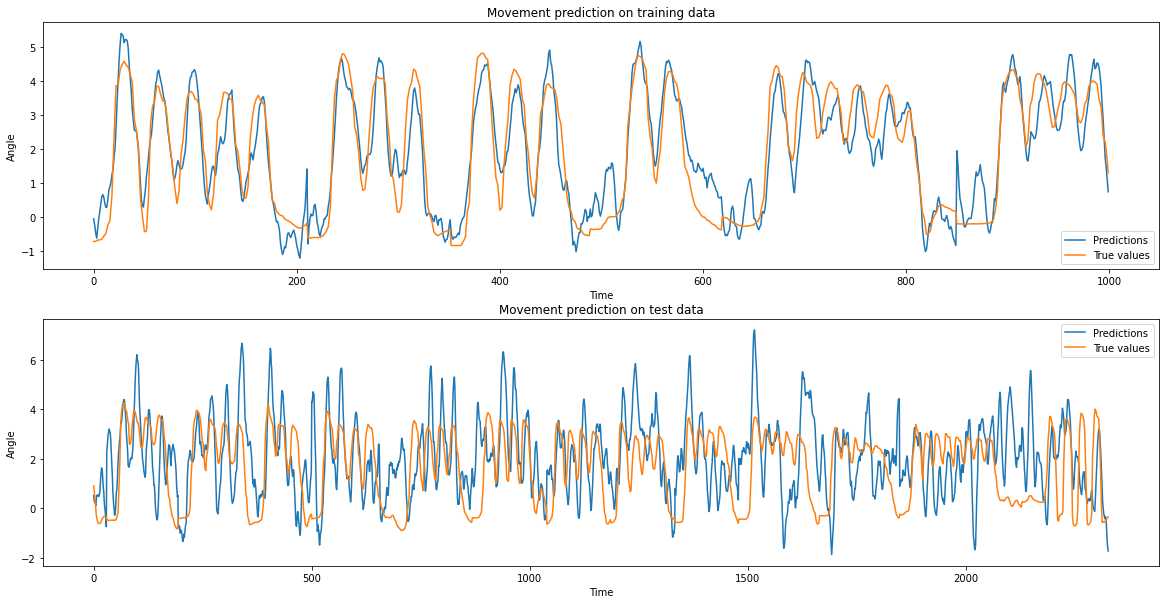

In [13]:
fig = plt.figure(figsize=(20, 10))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.plot(predictions_train, label="Predictions")
plt.plot(Ytrain, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on training data")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot(predictions_test, label="Predictions")
plt.plot(Ytest.values, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on test data")
plt.legend()

The movement prediction on test data is clearly not good. The prediction line is very different from the original line.

In contrast, we notice that the movement prediction for training data is good. The resulted line is not perfect but it is close to the original one

The model seems to be overfitting.

In [14]:
LR_MSE_train = mean_squared_error(Ytrain, predictions_train)
LR_R2_train = r2_score(Ytrain, predictions_train)

print("MSE_train = "+str(LR_MSE_train))
print("R2_train = "+str(LR_R2_train))

MSE_train = 0.5040654614476062
R2_train = 0.8395001217500111


In [15]:
LR_MSE_test = mean_squared_error(Ytest, predictions_test)
LR_R2_test = r2_score(Ytest, predictions_test)

print("MSE_test = "+str(LR_MSE_test))
print("R2_test = "+str(LR_R2_test))

MSE_test = 3.045536876760146
R2_test = -0.4281700630222449


We notice that the model is very performant for training data. While the model is very bad for test data. On training data MSE is 0.5 and on test data it is rouglhy 3. In addition, on training data R² is 0.8 and on test data it is rouglhy -0.4. There is a big difference between performances on both datasets. The model is clearly overfitting. We need to try a regularization method.

### Ridge Regression

In [16]:
ridge = Ridge()

ridge.fit(Xtrain, Ytrain)

predictions_test = ridge.predict(Xtest)
predictions_train = ridge.predict(Xtrain)

In [17]:
MSE_train = mean_squared_error(Ytrain, predictions_train)
R2_train = r2_score(Ytrain, predictions_train)

print("MSE_train = "+str(MSE_train))
print("R2_train = "+str(R2_train))

MSE_train = 0.5041768297327897
R2_train = 0.8394646608871272


In [18]:
MSE_test = mean_squared_error(Ytest, predictions_test)
R2_test = r2_score(Ytest, predictions_test)

print("MSE_test = "+str(MSE_test))
print("R2_test = "+str(R2_test))

MSE_test = 3.003842959535568
R2_test = -0.40861817223916064


We can notice that performances are almost the same as the Linear Regression performances. We need find an optimal value of λ. Let's study the influence of λ (the regularization factor) on performances:

In [19]:
regulizators = np.logspace(-3,5,100)

Text(0.5, 1.0, 'evolution of the linear parameters as a function of λ')

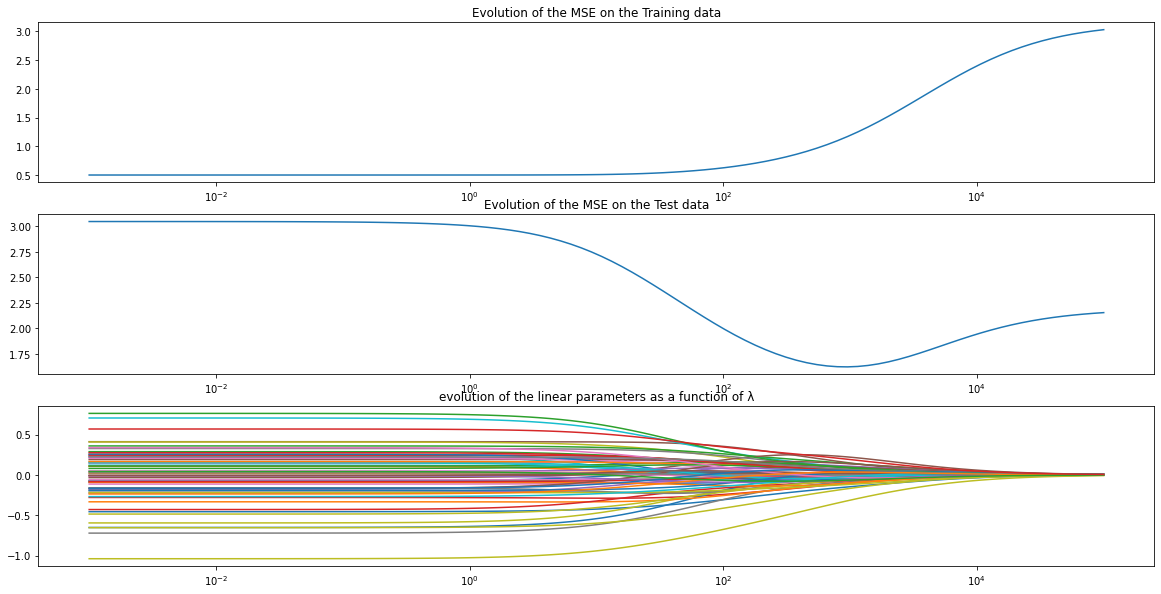

In [20]:
MSE_Train = []
MSE_Test = []
params=[]

for regulizator in regulizators:
    clf = Ridge(alpha=regulizator)
    clf.fit(Xtrain, Ytrain)
    predictions_train = clf.predict(Xtrain)
    predictions_test = clf.predict(Xtest)
    params.append(clf.coef_)
    MSE_Train.append(mean_squared_error(Ytrain, predictions_train))
    MSE_Test.append(mean_squared_error(Ytest, predictions_test))
    
params=np.array(params)
params = params.reshape(100,64)

fig = plt.figure(figsize=(20, 10))
rows = 3
columns = 1

fig.add_subplot(rows, columns, 1)
plt.xscale('log')
plt.plot(regulizators, MSE_Train)
plt.title("Evolution of the MSE on the Training data")

fig.add_subplot(rows, columns, 2)
plt.xscale('log')
plt.plot(regulizators, MSE_Test)
plt.title("Evolution of the MSE on the Test data")

fig.add_subplot(rows, columns, 3)
plt.xscale('log')
for i in range(0,64):
    y=params[:,i:i+1]
    plt.plot(regulizators,y)
plt.title("evolution of the linear parameters as a function of λ")

The plot on the evolution of the MSE shows that the higher lambda is, the worse the MSE on training data will be.

The plot on the evolution of the linear parameters shows that the higher lambda is and the closer to 0 parameters will be. It makes sense because Ridge regularization always shrinks the values of parameters. And if the value of lambda is very high it forces the parameters to be very low.

"

Let's make a Ridge model with the best value of lambda:

In [21]:
min_reg = np.argmin(MSE_Test)
best_lambda = regulizators[min_reg]
print("The best value of lambda is : "+str(best_lambda))

The best value of lambda is : 954.5484566618347


In [22]:
ridge = Ridge(alpha=best_lambda)

ridge.fit(Xtrain, Ytrain)

Ridge(alpha=954.5484566618347)

In [23]:
predictions_train = ridge.predict(Xtrain)
predictions_test = ridge.predict(Xtest)
w_Ridge = ridge.coef_.reshape(64,1)

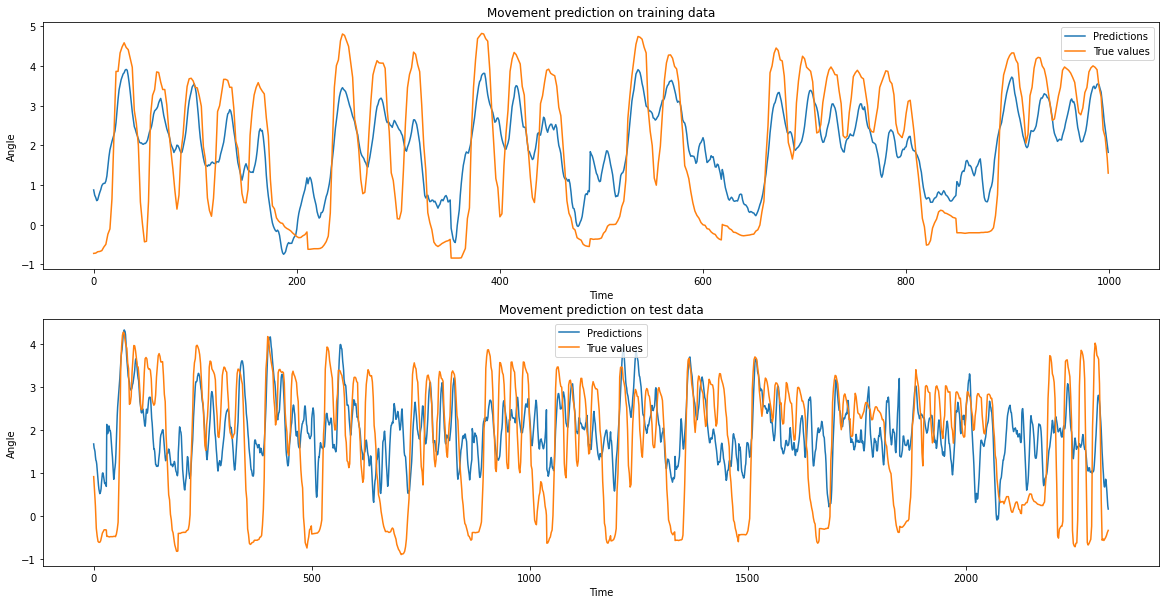

In [24]:
fig = plt.figure(figsize=(20, 10))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.plot(predictions_train, label="Predictions")
plt.plot(Ytrain, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on training data")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot(predictions_test, label="Predictions")
plt.plot(Ytest.values, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on test data")
plt.legend()

In [25]:
Ridge_MSE_train = mean_squared_error(Ytrain, predictions_train)
Ridge_R2_train = r2_score(Ytrain, predictions_train)

print("Ridge_MSE_train = "+str(Ridge_MSE_train))
print("Ridge_R2_train = "+str(Ridge_R2_train))

Ridge_MSE_train = 1.1719430382009632
Ridge_R2_train = 0.6268406996047915


In [26]:
Ridge_MSE_test = mean_squared_error(Ytest, predictions_test)
Ridge_R2_test = r2_score(Ytest, predictions_test)

print("Ridge_MSE_test = "+str(Ridge_MSE_test))
print("Ridge_R2_test = "+str(Ridge_R2_test))

Ridge_MSE_test = 1.6239059826952074
Ridge_R2_test = 0.23848766129037868


First, if we compare LS and Ridge performances for training data we notice that performances with the Ridge regression (MSE = 1.1 and R²=0.6) are less good than performances with the LS (MSE = 0.5 and R² = 0.83). It means that the regularization worked well and managed to make our model less biased.

Then when we compare LS and Ridge performances for test data we notice that performances with the Ridge (MSE=1.6 and R² = 0.23) are better than performances with the LS (MSE = 3 and R²=-0.4). Here again it shows that the regularization worked well and made our model more performant on test data. Our model seems less overfitted than with LS.

### Lasso Regression

We will start by looking for a good value for the lambda parameter:

Text(0.5, 1.0, 'Evolution of the linear parameters as a function of λ')

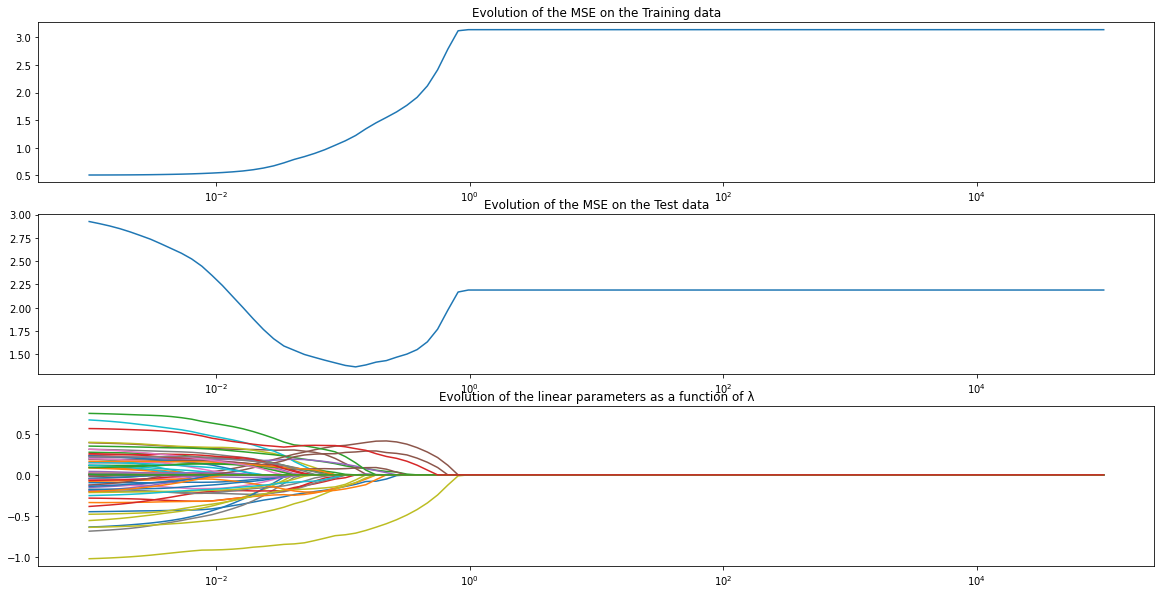

In [27]:
MSE_Train = []
MSE_Test = []
params=[]

for regulizator in regulizators:
    clf = Lasso(alpha=regulizator)
    clf.fit(Xtrain, Ytrain)
    predictions_train = clf.predict(Xtrain)
    predictions_test = clf.predict(Xtest)
    params.append(clf.coef_)
    MSE_Train.append(mean_squared_error(Ytrain, predictions_train))
    MSE_Test.append(mean_squared_error(Ytest, predictions_test))
    
params=np.array(params)
params = params.reshape(100,64)

fig = plt.figure(figsize=(20, 10))
rows = 3
columns = 1

fig.add_subplot(rows, columns, 1)
plt.xscale('log')
plt.plot(regulizators, MSE_Train)
plt.title("Evolution of the MSE on the Training data")

fig.add_subplot(rows, columns, 2)
plt.xscale('log')
plt.plot(regulizators, MSE_Test)
plt.title("Evolution of the MSE on the Test data")

fig.add_subplot(rows, columns, 3)
plt.xscale('log')
for i in range(0,64):
    y=params[:,i:i+1]
    plt.plot(regulizators,y)
plt.title("Evolution of the linear parameters as a function of λ")

Lasso shrinks the coefficient estimates towards zero and it has the effect of setting variables exactly equal to zero when the variable is not relevant enough. Here we notice that when lambda is optimal for the test data, multiple parameters are equal to 0. Therefore, the advandage with Lasso is that it is a combination of both shrinkage and selection of variables. 

In this case it is not relevant to choose a lambda equal or higher than 1. Because as we can see on the plot above, from lambda=1 the parameter vector is a zero vector.

"

Let's make a Lasso model with the best value of lambda:

In [28]:
min_reg = np.argmin(MSE_Test)
best_lasso_lambda = regulizators[min_reg]
print("The best value of lambda is : "+str(best_lasso_lambda))

The best value of lambda is : 0.1261856883066021


In [29]:
lasso = Lasso(alpha=best_lasso_lambda)
lasso.fit(Xtrain, Ytrain)

Lasso(alpha=0.1261856883066021)

In [30]:
predictions_train = lasso.predict(Xtrain)
predictions_test = lasso.predict(Xtest)
w_Lasso = lasso.coef_.reshape(64,1)

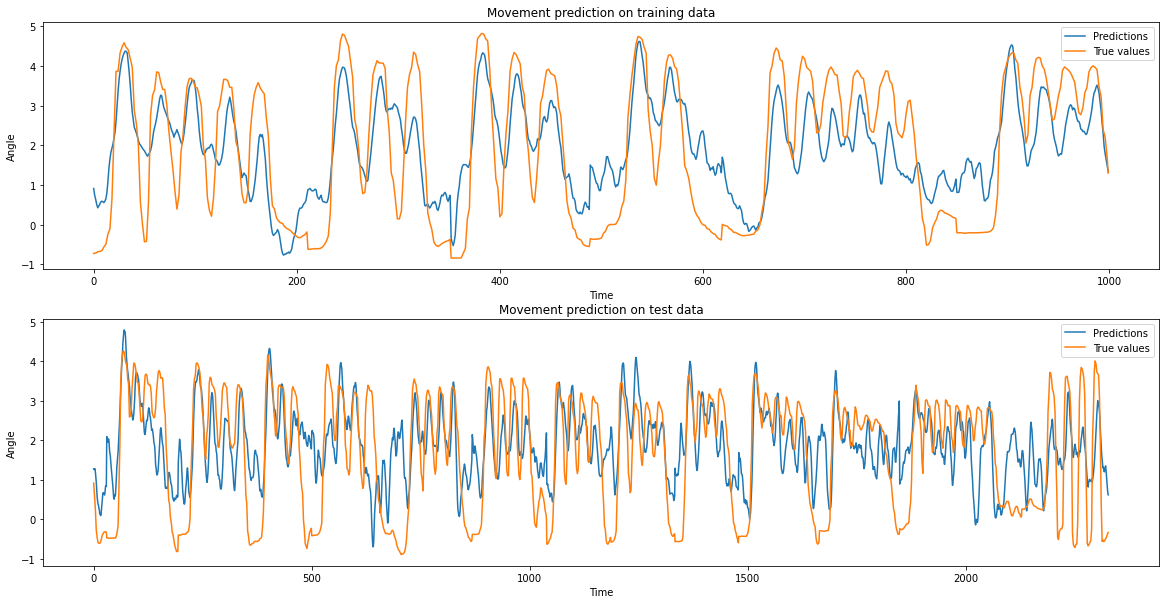

In [31]:
fig = plt.figure(figsize=(20, 10))
rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)
plt.plot(predictions_train, label="Predictions")
plt.plot(Ytrain, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on training data")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot(predictions_test, label="Predictions")
plt.plot(Ytest.values, label="True values")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Movement prediction on test data")
plt.legend()

In [32]:
Lasso_MSE_train = mean_squared_error(Ytrain, predictions_train)
Lasso_R2_train = r2_score(Ytrain, predictions_train)

print("Lasso_MSE_train = "+str(Lasso_MSE_train))
print("Lasso_R2_train = "+str(Lasso_R2_train))

Lasso_MSE_train = 1.2215631527944377
Lasso_R2_train = 0.6110411200657935


In [33]:
Lasso_MSE_test = mean_squared_error(Ytest, predictions_test)
Lasso_R2_test = r2_score(Ytest, predictions_test)

print("Lasso_MSE_test = "+str(Lasso_MSE_test))
print("Lasso_R2_test = "+str(Lasso_R2_test))

Lasso_MSE_test = 1.3659542352560023
Lasso_R2_test = 0.359451214944292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a s

Text(0.5, 1.0, 'Lasso weights')

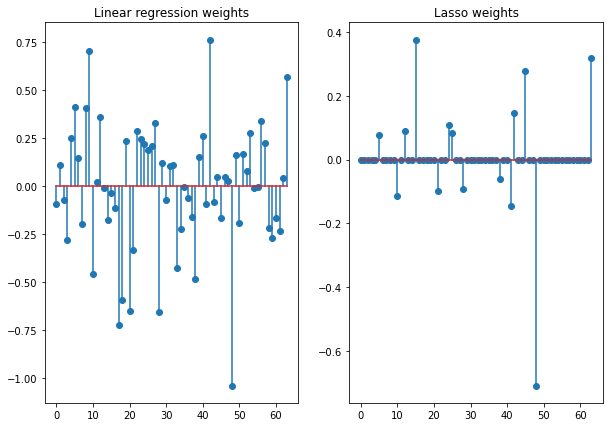

In [34]:
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.stem(w)
plt.title("Linear regression weights")

fig.add_subplot(rows, columns, 2)
plt.stem(w_Lasso)
plt.title("Lasso weights")

On the above plots, we can clearly see that for the Lasso regression a lot of parameters are equal to 0. Only 14 parameters are useful here. Therefore, if we reduce the number of electrodes on the subject it will not impact the quality of our model.

We saw earlier that Lasso's performances are better than Ridge's performances. In addition, Lasso has the advantage of selectionning parameters. Therefore, it would be possible to use less captors with a Lasso regressor. This could be more practical for the medical study.

### Random Forest regressor

In [35]:
RFr = RandomForestRegressor(random_state=42)
RFr.fit(Xtrain, Ytrain)

predictions_train = RFr.predict(Xtrain)
predictions_test = RFr.predict(Xtest)

In [36]:
RFr_MSE_train = mean_squared_error(Ytrain, predictions_train)
RFr_R2_train = r2_score(Ytrain, predictions_train)

print("RFr_MSE_train = "+str(RFr_MSE_train))
print("RFr_R2_train = "+str(RFr_R2_train))

RFr_MSE_train = 0.02232492543528405
RFr_R2_train = 0.9928915030123014


In [37]:
RFr_MSE_test = mean_squared_error(Ytest, predictions_test)
RFr_R2_test = r2_score(Ytest, predictions_test)

print("RFr_MSE_test = "+str(RFr_MSE_test))
print("RFr_R2_test = "+str(RFr_R2_test))

RFr_MSE_test = 1.6256841820937247
RFr_R2_test = 0.23765379479990023


The model is clearly overfitting. Let's try a GridSearchCV to improve performances

In [44]:
cv = TimeSeriesSplit(n_splits=10)
params = {'max_depth' : [2,5,7,10,30,50,100,150]}   

RFr = RandomForestRegressor(random_state=42)
gridSearch = GridSearchCV(RFr,params,cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
gridSearch.fit(Xtrain,Ytrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 10, 30, 50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [45]:
gridSearch.best_params_

{'max_depth': 30}

In [46]:
predictions_train = gridSearch.predict(Xtrain)
predictions_test = gridSearch.predict(Xtest)

In [47]:
GS_RFr_MSE_train = mean_squared_error(Ytrain, predictions_train)
GS_RFr_R2_train = r2_score(Ytrain, predictions_train)

print("RFr_MSE_train = "+str(GS_RFr_MSE_train))
print("RFr_R2_train = "+str(GS_RFr_R2_train))

RFr_MSE_train = 0.02232492543528405
RFr_R2_train = 0.9928915030123014


In [48]:
GS_RFr_MSE_test = mean_squared_error(Ytest, predictions_test)
GS_RFr_R2_test = r2_score(Ytest, predictions_test)

print("RFr_MSE_test = "+str(GS_RFr_MSE_test))
print("RFr_R2_test = "+str(GS_RFr_R2_test))

RFr_MSE_test = 1.6256841820937247
RFr_R2_test = 0.23765379479990023


We can notice that our parameter tuning is not very efficient, we obtain the same performances. In this case, maybe the best parameters are very closed to the default ones.

### SVR (Support Vector machine)

In [49]:
svr = SVR()
svr.fit(Xtrain, Ytrain)

predictions_train = svr.predict(Xtrain)
predictions_test = svr.predict(Xtest)

In [50]:
svr_MSE_train = mean_squared_error(Ytrain, predictions_train)
svr_R2_train = r2_score(Ytrain, predictions_train)

print("svr_MSE_train = "+str(svr_MSE_train))
print("svr_R2_train = "+str(svr_R2_train))

svr_MSE_train = 0.024085982516610357
svr_R2_train = 0.9923307634481734


In [51]:
svr_MSE_test = mean_squared_error(Ytest, predictions_test)
svr_R2_test = r2_score(Ytest, predictions_test)

print("svr_MSE_test = "+str(svr_MSE_test))
print("svr_R2_test = "+str(svr_R2_test))

svr_MSE_test = 1.515182870123942
svr_R2_test = 0.28947213490412815


Let's try to optimize performances with a gridSearch

In [52]:
C = np.logspace(-3,2,10)
params = {'C':np.linspace(0.001,10,100), "gamma":[1,10,20,50,100,1000,'auto','scale']}

svr = SVR()
gridSearch = GridSearchCV(svr,params,cv=cv, n_jobs=-1)
gridSearch.fit(Xtrain,Ytrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([1.000e-03, 1.020e-01, 2.030e-01, 3.040e-01, 4.050e-01, 5.060e-01,
       6.070e-01, 7.080e-01, 8.090e-01, 9.100e-01, 1.011e+00, 1.112e+00,
       1.213e+00, 1.314e+00, 1.415e+00, 1.516e+00, 1.617e+00, 1.718e+00,
       1.819e+00, 1.920e+00, 2.021e+00, 2.122...
       6.667e+00, 6.768e+00, 6.869e+00, 6.970e+00, 7.071e+00, 7.172e+00,
       7.273e+00, 7.374e+00, 7.475e+00, 7.576e+00, 7.677e+00, 7.778e+00,
       7.879e+00, 7.980e+00, 8.081e+00, 8.182e+00, 8.283e+00, 8.384e+00,
       8.485e+00, 8.586e+00, 8.687e+00, 8.788e+00, 8.889e+00, 8.990e+00,
       9.091e+00, 9.192e+00, 9.293e+00, 9.394e+00, 9.495e+00, 9.596e+00,
       9.697e+00, 9.798e+00, 9.899e+00, 1.000e+01]),
                         'gamma': [1, 10, 20, 50, 100, 1000, 'auto', 'scale']})

In [53]:
gridSearch.best_params_

{'C': 0.30400000000000005, 'gamma': 'scale'}

In [54]:
predictions_train = gridSearch.predict(Xtrain)
predictions_test = gridSearch.predict(Xtest)

In [55]:
GS_svr_MSE_train = mean_squared_error(Ytrain, predictions_train)
GS_svr_R2_train = r2_score(Ytrain, predictions_train)

print("svr_MSE_train = "+str(GS_svr_MSE_train))
print("svr_R2_train = "+str(GS_svr_R2_train))

svr_MSE_train = 0.24111749526896187
svr_R2_train = 0.9232255895425338


In [56]:
GS_svr_MSE_test = mean_squared_error(Ytest, predictions_test)
GS_svr_R2_test = r2_score(Ytest, predictions_test)

print("svr_MSE_test = "+str(GS_svr_MSE_test))
print("svr_R2_test = "+str(GS_svr_R2_test))

svr_MSE_test = 1.5399740340525783
svr_R2_test = 0.2778465990518024


### MLP

In [58]:
MLP=MLPRegressor()

MLP.fit(Xtrain, Ytrain)
predictions_test = MLP.predict(Xtest)
predictions_train = MLP.predict(Xtrain)

In [59]:
MLP_MSE_train = mean_squared_error(Ytrain, predictions_train)
MLP_R2_train = r2_score(Ytrain, predictions_train)

print("MLP_MSE_train = "+str(MLP_MSE_train))
print("MLP_R2_train = "+str(MLP_R2_train))

MLP_MSE_train = 0.009147649221463943
MLP_R2_train = 0.9970872898490166


In [60]:
MLP_MSE_test = mean_squared_error(Ytest, predictions_test)
MLP_R2_test = r2_score(Ytest, predictions_test)

print("MLP_MSE_test = "+str(MLP_MSE_test))
print("MLP_R2_test = "+str(MLP_R2_test))

MLP_MSE_test = 2.3559684522527897
MLP_R2_test = -0.1048047517033166


Let's try to improve performances by tuning (by hand) the hidden_layer_sizes parameter

In [127]:
MLP = MLPRegressor(hidden_layer_sizes=(1000,700,500), activation='relu') 
MLP.fit(Xtrain, Ytrain)

MLPRegressor(hidden_layer_sizes=(1000, 700, 500))

In [128]:
predictions_test = MLP.predict(Xtest)
predictions_train = MLP.predict(Xtrain)

In [129]:
GS_MLP_MSE_train = mean_squared_error(Ytrain, predictions_train)
GS_MLP_R2_train = r2_score(Ytrain, predictions_train)

print("MLP_MSE_train = "+str(GS_MLP_MSE_train))
print("MLP_R2_train = "+str(GS_MLP_R2_train))

MLP_MSE_train = 0.0014160935608329758
MLP_R2_train = 0.9995491005405299


In [130]:
GS_MLP_MSE_test = mean_squared_error(Ytest, predictions_test)
GS_MLP_R2_test = r2_score(Ytest, predictions_test)

print("MLP_MSE_test = "+str(GS_MLP_MSE_test))
print("MLP_R2_test = "+str(GS_MLP_R2_test))

MLP_MSE_test = 1.7766051202158295
MLP_R2_test = 0.16688112829437562


By tuning the hidden_layer_sizes parameter by hand we manage to get better performances than with default parameters. However the model is still overfitting and performances on test data are worse than performances obtained with all previous models. This could be explained by the fact that our dataset does not have enough data (only 1000 samples). 

### Discussion of models performances

In [131]:
LS = {"MSE_train":LR_MSE_train, "MSE_test":LR_MSE_test, "R²_train":LR_R2_train, "R²_test":LR_R2_test}
Ridge = {"MSE_train":Ridge_MSE_train, "MSE_test":Ridge_MSE_test, "R²_train":Ridge_R2_train, "R²_test":Ridge_R2_test}
Lasso = {"MSE_train":Lasso_MSE_train, "MSE_test":Lasso_MSE_test, "R²_train":Lasso_R2_train, "R²_test":Lasso_R2_test}
RFr = {"MSE_train":RFr_MSE_train, "MSE_test":RFr_MSE_test, "R²_train":RFr_R2_train, "R²_test":RFr_R2_test}
svr = {"MSE_train":svr_MSE_train, "MSE_test":svr_MSE_test, "R²_train":svr_R2_train, "R²_test":svr_R2_test}
MLP = {"MSE_train":MLP_MSE_train, "MSE_test":MLP_MSE_test, "R²_train":MLP_R2_train, "R²_test":MLP_R2_test}

LR = pd.Series(LS)
Ridge = pd.Series(Ridge)
Lasso = pd.Series(Lasso)
RFr = pd.Series(RFr)
svr = pd.Series(svr)
MLP = pd.Series(MLP)

tab = pd.DataFrame({"LR":LR, "Ridge":Ridge, "Lasso":Lasso, "Random_Forest":RFr, "SVR":svr, "MLP":MLP})
display(tab.T)

,MSE_train,MSE_test,R²_train,R²_test
LR,0.504065,3.045537,0.839500,-0.428170
Ridge,1.171943,1.623906,0.626841,0.238488
Lasso,1.221563,1.365954,0.611041,0.359451
Random_Forest,0.022325,1.625684,0.992892,0.237654
SVR,0.024086,1.515183,0.992331,0.289472
MLP,0.009148,2.355968,0.997087,-0.104805


The best method in term of test performances is the Lasso.

In my opinion, for the problematic we are facing it is better to use linear models (from a practical and medical perspective). Indeed, linear models are easier to interpret. They have one weight for every parameter that you can easily analyse . Therefore, for this application it could be more practical to use a linear model in order to have a better understanding of our model. The model interpretation could be share with health professionals in order to improve the model. This could help them to understand the phenomenona and to precisely locate the areas responsible for the movements.

In contrast, non-linear models such as MLP are much more complex to interpret : all the weights that we get are very difficult to interptret, very fuzzy.

In addition, the Lasso regression allows to make a very useful feature selection. Indeed, this feature selection could allow to use less captors. It could be more practical for the study : for people doing signal measurements and for the subjects.

However, in term of performances we still need to improve our models because performances are not good enough. In addition, we can notice that for most model there is a tendency underestimate the flexion (as you can see below with the Lasso prediction which is the best model we found)
